# Dome C Sensitivity Estimates

Compute the sensitivity of the $^{14}$CO profile shape at Dome C to changes in the GCR flux relative to a steady-state model.

In [110]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from cycler import cycler

from scipy.stats import norm

from coprofile import COProfile
from likelihood import ModelLikelihood

import random

from time import time

In [111]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

## Baseline Production Model

Using the average $f\Omega_{\mu_f}$ and $f\Omega_{\mu_{-1}}$ values from the simulations by Hmiel and Dyonisius, we can pick a couple of baseline models.

In [112]:
fmu_neg, fmu_fast = 0.066, 0.072

## $^{14}$CO model classes

These encapsulate models corresponding to specific hypotheses we want to test:

1. A constant model where the GCR flux does not change, but the models include an uncertainty in the cosmogenic production rate due to negative and fast muons. These are parameterized by $f\Omega_{\mu_f}$ and $f\Omega_{\mu_{-}}$.
2. A variable production model parameterized by some quantity that controls its time dependence; for example, a linear change in GCR flux parameterized by a factor $a$.

Both models should account for the number and ranges of free parameters internally.

When initializing, we specify the depth average and relative uncertainty of data sets generated using the models. The model profiles were generated by MATLAB programs provided in this project and packed into a compact [FITS format](https://fits.gsfc.nasa.gov/) for ease of use.

In [132]:
depthavg = 20.   # in meters
relerror = 0.02 

const_models = ModelLikelihood('models/balco_14co_const_models.fits', depth_avg=depthavg, rel_uncertainty=relerror)
linear_models = ModelLikelihood('models/balco_14co_linear_models_SMALL_FIX.fits', depth_avg=depthavg, rel_uncertainty=relerror)
step_models = ModelLikelihood('models/balco_14co_step_models_SMALL_FIX.fits', depth_avg=depthavg, rel_uncertainty=relerror)
burst_models = ModelLikelihood('models/balco_14co_burst_models.fits', depth_avg=depthavg, rel_uncertainty=relerror)

Models = [const_models, linear_models, step_models, burst_models] # 0: const; 1: linear; 2: step; 3: burst
modelNames = ['constant', 'linear', 'step', 'burst']

(Note to self:)

### ModelLikelihood class

self.likelihood(z_samp, CO_samp, dCO_samp) - returns likelihood of parameters given model, using a uniform prior on model parameters

self.models - COProfile of simulated data

self.amplitudes - amplitude parameters

self.fofactors - muon reaction parameters

self.parameters - all parameters

self.volume - total volume in parameter space

self.dtheta - unit volume in parameter space

self.logprior - log of Bayesian prior on parameters

### COProfile class

self.z - Depth array [m]

self.CO - 14CO concentration profile [molecules/g]

self.dCOrel - relative fractional uncertainty in concentration measurement

self.z_samp - z averaged over depth_avg step size [m]

self.CO_model - CO averaged over depth_avg step size [molecules/g]

self.sample_z() - samples from CO_model under gaussian uncertainty, returns z_samp, CO_samp, and scaled uncertainty

### Check the Model Parameters

Print out the range of parameters represented in each model. The constant model includes a range of production factors, while the variable models include amplitudes of linear/step/burst changes to the flux.

In [133]:
const_models.fofactors

FITS_rec([(0.056, 0.072), (0.056, 0.074), (0.056, 0.076), (0.056, 0.078),
          (0.056, 0.08 ), (0.056, 0.082), (0.056, 0.084), (0.056, 0.086),
          (0.056, 0.088), (0.056, 0.09 ), (0.058, 0.066), (0.058, 0.068),
          (0.058, 0.07 ), (0.058, 0.072), (0.058, 0.074), (0.058, 0.076),
          (0.058, 0.078), (0.058, 0.08 ), (0.058, 0.082), (0.058, 0.084),
          (0.058, 0.086), (0.058, 0.088), (0.06 , 0.062), (0.06 , 0.064),
          (0.06 , 0.066), (0.06 , 0.068), (0.06 , 0.07 ), (0.06 , 0.072),
          (0.06 , 0.074), (0.06 , 0.076), (0.06 , 0.078), (0.06 , 0.08 ),
          (0.06 , 0.082), (0.06 , 0.084), (0.06 , 0.086), (0.062, 0.06 ),
          (0.062, 0.062), (0.062, 0.064), (0.062, 0.066), (0.062, 0.068),
          (0.062, 0.07 ), (0.062, 0.072), (0.062, 0.074), (0.062, 0.076),
          (0.062, 0.078), (0.062, 0.08 ), (0.062, 0.082), (0.062, 0.084),
          (0.064, 0.058), (0.064, 0.06 ), (0.064, 0.062), (0.064, 0.064),
          (0.064, 0.066), (0.064, 0.06

In [134]:
linear_models.amplitudes

FITS_rec([(0.5 ,), (0.51,), (0.52,), (0.53,), (0.54,), (0.55,), (0.56,),
          (0.57,), (0.58,), (0.59,), (0.6 ,), (0.61,), (0.62,), (0.63,),
          (0.64,), (0.65,), (0.66,), (0.67,), (0.68,), (0.69,), (0.7 ,),
          (0.71,), (0.72,), (0.73,), (0.74,), (0.75,), (0.76,), (0.77,),
          (0.78,), (0.79,), (0.8 ,), (0.81,), (0.82,), (0.83,), (0.84,),
          (0.85,), (0.86,), (0.87,), (0.88,), (0.89,), (0.9 ,), (0.91,),
          (0.92,), (0.93,), (0.94,), (0.95,), (0.96,), (0.97,), (0.98,),
          (0.99,), (1.  ,), (1.01,), (1.02,), (1.03,), (1.04,), (1.05,),
          (1.06,), (1.07,), (1.08,), (1.09,), (1.1 ,), (1.11,), (1.12,),
          (1.13,), (1.14,), (1.15,), (1.16,), (1.17,), (1.18,), (1.19,),
          (1.2 ,), (1.21,), (1.22,), (1.23,), (1.24,), (1.25,), (1.26,),
          (1.27,), (1.28,), (1.29,), (1.3 ,), (1.31,), (1.32,), (1.33,),
          (1.34,), (1.35,), (1.36,), (1.37,), (1.38,), (1.39,), (1.4 ,),
          (1.41,), (1.42,), (1.43,), (1.44,), (1.45

In [135]:
step_models.amplitudes

FITS_rec([(0.5 ,), (0.51,), (0.52,), (0.53,), (0.54,), (0.55,), (0.56,),
          (0.57,), (0.58,), (0.59,), (0.6 ,), (0.61,), (0.62,), (0.63,),
          (0.64,), (0.65,), (0.66,), (0.67,), (0.68,), (0.69,), (0.7 ,),
          (0.71,), (0.72,), (0.73,), (0.74,), (0.75,), (0.76,), (0.77,),
          (0.78,), (0.79,), (0.8 ,), (0.81,), (0.82,), (0.83,), (0.84,),
          (0.85,), (0.86,), (0.87,), (0.88,), (0.89,), (0.9 ,), (0.91,),
          (0.92,), (0.93,), (0.94,), (0.95,), (0.96,), (0.97,), (0.98,),
          (0.99,), (1.  ,), (1.01,), (1.02,), (1.03,), (1.04,), (1.05,),
          (1.06,), (1.07,), (1.08,), (1.09,), (1.1 ,), (1.11,), (1.12,),
          (1.13,), (1.14,), (1.15,), (1.16,), (1.17,), (1.18,), (1.19,),
          (1.2 ,), (1.21,), (1.22,), (1.23,), (1.24,), (1.25,), (1.26,),
          (1.27,), (1.28,), (1.29,), (1.3 ,), (1.31,), (1.32,), (1.33,),
          (1.34,), (1.35,), (1.36,), (1.37,), (1.38,), (1.39,), (1.4 ,),
          (1.41,), (1.42,), (1.43,), (1.44,), (1.45

In [136]:
burst_models.amplitudes

FITS_rec([( 1.1,), ( 1.2,), ( 1.3,), ( 1.4,), ( 1.5,), ( 1.6,), ( 1.7,),
          ( 1.8,), ( 1.9,), (10. ,), ( 2. ,), ( 2.1,), ( 2.2,), ( 2.3,),
          ( 2.4,), ( 2.5,), ( 2.6,), ( 2.7,), ( 2.8,), ( 2.9,), ( 3. ,),
          ( 3.1,), ( 3.2,), ( 3.3,), ( 3.4,), ( 3.5,), ( 3.6,), ( 3.7,),
          ( 3.8,), ( 3.9,), ( 4. ,), ( 4.1,), ( 4.2,), ( 4.3,), ( 4.4,),
          ( 4.5,), ( 4.6,), ( 4.7,), ( 4.8,), ( 4.9,), ( 5. ,), ( 5.1,),
          ( 5.2,), ( 5.3,), ( 5.4,), ( 5.5,), ( 5.6,), ( 5.7,), ( 5.8,),
          ( 5.9,), ( 6. ,), ( 6.1,), ( 6.2,), ( 6.3,), ( 6.4,), ( 6.5,),
          ( 6.6,), ( 6.7,), ( 6.8,), ( 6.9,), ( 7. ,), ( 7.1,), ( 7.2,),
          ( 7.3,), ( 7.4,), ( 7.5,), ( 7.6,), ( 7.7,), ( 7.8,), ( 7.9,),
          ( 8. ,), ( 8.1,), ( 8.2,), ( 8.3,), ( 8.4,), ( 8.5,), ( 8.6,),
          ( 8.7,), ( 8.8,), ( 8.9,), ( 9. ,), ( 9.1,), ( 9.2,), ( 9.3,),
          ( 9.4,), ( 9.5,), ( 9.6,), ( 9.7,), ( 9.8,), ( 9.9,)],
         dtype=(numpy.record, [('AMPL', '>f8')]))

## Non-Uniform Prior

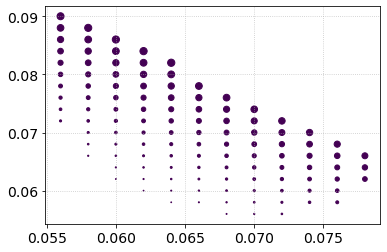

In [137]:
const_models.import_prior('14CO_f_all_ChiSq.csv')

plt.scatter(const_models.fofactors['FOMUNEG'],const_models.fofactors['FOMUFAST'], s=np.exp(const_models.logprior)*20)
plt.show()

In [10]:
linear_models.import_prior('14CO_f_all_ChiSq.csv')

In [11]:
step_models.import_prior('14CO_f_all_ChiSq.csv')

In [12]:
burst_models.import_prior('14CO_f_all_ChiSq.csv')

## Test Sampling from Models

This is not the main calculation, but it shows how we produce simulated $^{14}$CO data sets from the model profiles and compute Bayes Factors.

In [10]:
theta0s = [
        [fmu_neg, fmu_fast], # constant parameters
        [1.05, fmu_neg, fmu_fast], # linear parameters
        [1.05, fmu_neg, fmu_fast], # step parameters
        [1.5, fmu_neg, fmu_fast] # burst parameters
         ]

In [11]:
def param_dist(model, theta0, weights = [1]): # calculates distance in parameter space to theta0
    w = np.array(weights)
    theta0 = np.array(theta0)
    return np.sum(w * (model.parameters - theta0)**2, axis=1)

In [12]:
def param_chi2(model, CO_samp, dCO_samp):
    return np.sum(((model.CO_mods - CO_samp)/dCO_samp)**2, axis=1)

In [13]:
def plot_model(m, theta0 = []): # plots model# m against constant model, takes random sample, and calculates Bayes factors
    #dist = param_dist(const_models, [fmu_neg, fmu_fast])
    #i = dist.argmin()
    #data_const = const_models.models[i]
    
    #dist = param_dist(Models[m], theta0s[m])
    #j = dist.argmin()
    #data_lin = Models[m].models[j]
    if theta0 == []:
        j = random.choices(np.arange(len(Models[m].models)), weights=np.exp(Models[m].logprior))[0]
        data_lin = Models[m].models[j]
    else:
        dist = param_dist(Models[m], theta0)
        j = dist.argmin()
        data_lin = Models[m].models[j]
    print('params: {}'.format(Models[m].parameters[j]))
    
    z_samp, CO_samp, dCO_samp = data_lin.sample_z()
    
    chi2 = param_chi2(const_models, CO_samp, dCO_samp) - 2*const_models.logprior
    i = chi2.argmin()
    data_const = const_models.models[i]
    print('const params: {}'.format(const_models.parameters[i]))
    print(chi2[i])
    print()

    fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
    ax.plot(data_const.z, data_const.CO, 'r--', label='constant model')
    ax.plot(data_lin.z, data_lin.CO, label=modelNames[m]+' model')
    ax.errorbar(z_samp, CO_samp, yerr=dCO_samp, fmt='.')
    ax.set(xlim=(90,300),
           xlabel='depth [m]',
           ylim=(0,30),
           ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
    ax.legend(loc='lower right', fontsize=10)

    # Try out some likelihood ratio tests.
    B01 = const_models.likelihood(z_samp, CO_samp, dCO_samp) / linear_models.likelihood(z_samp, CO_samp, dCO_samp)
    print(f'B_01 = {B01:12g}; 0=const model, 1=linear model')

    B02 = const_models.likelihood(z_samp, CO_samp, dCO_samp) / step_models.likelihood(z_samp, CO_samp, dCO_samp)
    print(f'B_02 = {B02:12g}; 0=const model, 2=step model')

    B03 = const_models.likelihood(z_samp, CO_samp, dCO_samp) / burst_models.likelihood(z_samp, CO_samp, dCO_samp)
    print(f'B_03 = {B03:12g}; 0=const model, 3=burst model')

### Constant Models

params: [0.06  0.084]
const params: [0.062 0.084]
9.9911760578555

B_01 =  5.30283e+06; 0=const model, 1=linear model
B_02 =  3.31321e+18; 0=const model, 2=step model
B_03 =  1.19969e+21; 0=const model, 3=burst model


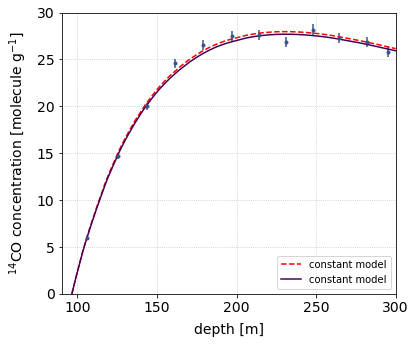

In [14]:
plot_model(0)
# The Bayes factors should all be large because we generated data from the constant model.

### Linear Models

params: [0.88  0.066 0.072]
const params: [0.056 0.082]
13.82503854735543

B_01 =     0.277955; 0=const model, 1=linear model
B_02 =       2.0299; 0=const model, 2=step model
B_03 =      42.9057; 0=const model, 3=burst model


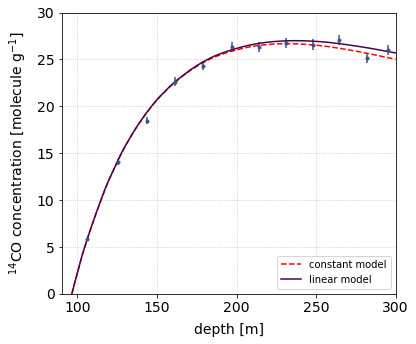

In [18]:
plot_model(1, [0.88, fmu_neg, fmu_fast])
# B_01 should be small, favoring the linear model.
# B_02 may be small, favoring the step model.
# B_03 could be large, favoring the constant model over the burst model.

### Step Models

params: [1.01  0.066 0.072]
const params: [0.066 0.072]
10.249783897686372

B_01 =      1.20412; 0=const model, 1=linear model
B_02 =       1.2457; 0=const model, 2=step model
B_03 =     0.724725; 0=const model, 3=burst model


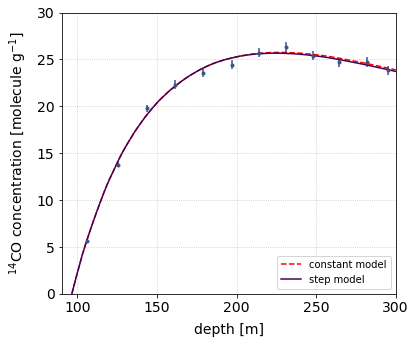

In [19]:
plot_model(2)
# B_01 may be small, favoring the linear model.
# B_02 should be small, favoring the step model.
# B_03 could be large, favoring the constant model over the burst model.

### Burst Models

params: [5.9]
const params: [0.056 0.084]
80.90302120829745

B_01 =   0.00164264; 0=const model, 1=linear model
B_02 =  4.98954e-05; 0=const model, 2=step model
B_03 =  6.32347e-17; 0=const model, 3=burst model


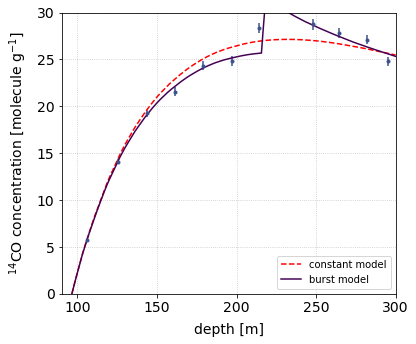

In [20]:
plot_model(3)
# B_01 could be large, favoring the constant model over a linear model.
# B_02 could be large, favoring a constant model over a step model.
# B_03 should be small, favoring the burst model.

## Test Bayes Factor Computation

### Alternative Hypothesis: Linear Model

Test two cases:
1. A middle-of-the-road constant model, and compute the Bayes Factor $B_{01}$, where model 0 is hypothesis of a constant flux (with negative and fast muon rates as nuisance parameters) and model 1 is a linear growth/decrease hypothesis (with negative and fast muon rates fixed and growth amplitude the nuisance parameter).
2. A middle-of-the-road linear increase model (15% increase over 6000 yr).

In case 1, expect $B_{01}>1$ on average, and in case 2, expect $B_{01}<1$ on average.

In [22]:
dist = param_dist(const_models, [fmu_neg, fmu_fast])
j = dist.argmin()
data_const = const_models.models[j]

N = 10000
#data_const_mult = random.choices(const_models.models, weights=np.exp(const_models.logprior),k=N)

# Generate B_01, where 0=const model and 1=linear model,
# under the null hypothesis where the data are produced by the "baseline" constant model.
BF_lin_null = []
for i in tqdm(range(N)):
    z_samp, CO_samp, dCO_samp = data_const.sample_z()
    #z_samp, CO_samp, dCO_samp = data_const_mult[i].sample_z()
    B = const_models.likelihood(z_samp, CO_samp, dCO_samp) / linear_models.likelihood(z_samp, CO_samp, dCO_samp)
    BF_lin_null.append(B)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 17794.11it/s]


In [23]:
dist = param_dist(linear_models, [0.88, fmu_neg, fmu_fast])
j = dist.argmin()
data_lin = linear_models.models[j]

N = 10000
#data_lin_mult = random.choices(linear_models.models, weights=np.exp(linear_models.logprior),k=N)

# Generate B_01, where 0=const model and 1=linear model,
# under the alternative hypothesis where the data are produced
# by a middle-of-the-road linear model.
BF_lin = []
for i in tqdm(range(N)):
    z_samp, CO_samp, dCO_samp = data_lin.sample_z()
    #z_samp, CO_samp, dCO_samp = data_lin_mult[i].sample_z()
    B = const_models.likelihood(z_samp, CO_samp, dCO_samp) / linear_models.likelihood(z_samp, CO_samp, dCO_samp)
    BF_lin.append(B)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 17636.73it/s]


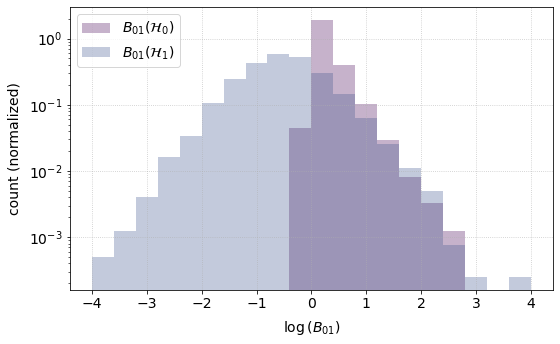

In [24]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

logBmin = np.maximum(np.round(np.log10(np.min(np.minimum(BF_lin_null, BF_lin)))),-20)
logBmax = np.minimum(np.round(np.log10(np.max(np.maximum(BF_lin_null, BF_lin)))),10)
nbins = int(np.round((logBmax - logBmin) / 0.4) + 1)

ax.hist(np.log10(BF_lin_null), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.3, density=1,
        label=r'$B_{01}(\mathcal{H}_0)$');
ax.hist(np.log10(BF_lin), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.3, density=1,
        label=r'$B_{01}(\mathcal{H}_1)$');
ax.set(xlabel=r'$\log{(B_{01})}$',
       ylabel='count (normalized)',
       yscale='log')

ax.legend(loc='upper left')

fig.tight_layout()

## Null Distributions for All Hypotheses

Read in the distributions of the Bayes Factor for all three alternative hypotheses (linear change, step change, burst) generated under the null hypothesis of a constant GCR flux. Note that for the null hypothesis, a baseline model corresponding to $f\Omega_{\mu_{-}}=0.066$ and $f\Omega_{\mu_f}=0.072$ was used.

The distributions were generated using the external `null-generator.py` script.

In [157]:
#file = 'models/bf_null_20m_2pct_0.0660_0.0720.npz' #single null model, uniform parameter priors, no f-factors for var. models
#file = 'models/bf_null_20m_2pct_5000000_01.npz'
#file = 'models/bf_null_20m_2pct_5000000_02.npz' # random null models, non-uniform parameter priors, f-factors for var. models
#file = 'models/bf_null_20m_2pct_5000000_03.npz' # variable model amplitude fixed at present day
file = 'models/bf_null_20m_2pct_5000000_04.npz' # variable model amplitude fixed at present day, no f-factors for var. models
#file = 'models/bf_null_20m_2pct_5000000_05.npz' # random null models, non-uniform parameter priors, no f-factors for var. mods
#file = 'models/bf_null_20m_2pct_5000000_06.npz' # single null model, non-uniform parameter priors, no f-factors for var. mods
#file = 'models/bf_null_20m_2pct_5000000_07.npz' # single, non-uniform, no f-factors, fixed at present
if os.path.exists(file):
    npzf = np.load(file)
    BF_lin_null = npzf['BF_lin']
    BF_step_null = npzf['BF_step']
    BF_100yr_null = npzf['BF_100yr']
    BF_null = [BF_lin_null, BF_step_null, BF_100yr_null]
else:
    print('Null data path does not exist')

In [158]:
N = len(BF_lin_null)

sigs = [3,4,5]

i = np.array([np.maximum(int(norm.sf(x)*N)-1,0) for x in sigs])
print(i)

sig_thr = np.array([np.sort(nulls)[i] for nulls in BF_null])
print(sig_thr)

[6748  157    0]
[[5.16511296e-02 1.88443983e-03 3.29069830e-05]
 [7.27006176e-02 2.65293027e-03 2.25382286e-05]
 [5.22086373e-02 1.85008374e-03 1.23893760e-06]]


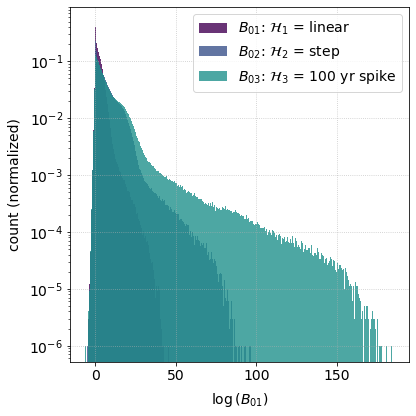

In [159]:
BFlim = (-20,500)

logBmin = np.maximum(np.round(np.log10(np.min(np.minimum(np.minimum(BF_lin_null, BF_100yr_null), BF_step_null)))),BFlim[0])
logBmax = np.minimum(np.round(np.log10(np.max(np.maximum(np.maximum(BF_lin_null, BF_100yr_null), BF_step_null)))),BFlim[1])
nbins = int(np.round((logBmax - logBmin) / 0.2) + 1)

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.hist(np.log10(BF_lin_null), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
        label=r'$B_{01}$: $\mathcal{H}_1$ = linear');
ax.hist(np.log10(BF_step_null), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
        label=r'$B_{02}$: $\mathcal{H}_2$ = step');
ax.hist(np.log10(BF_100yr_null), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
        label=r'$B_{03}$: $\mathcal{H}_3$ = 100 yr spike');
ax.set(xlabel=r'$\log{(B_{01})}$',
       ylabel='count (normalized)',
       yscale='log')

ax.legend(loc='best')

fig.tight_layout()

## Compute Sensitivity Thresholds

Here we compute the discovery potential for a signal by varying the amplitudes of the variable models and assessing how often the Bayes Factor of our realized data sets puts us into the $3\sigma$ and $5\sigma$ tails of the null distributions.

The sensitivity is defined as the signal amplitude(s) that give a $3\sigma$ or $5\sigma$ "discovery," assuming the null hypothesis is correct, in at least 50% of random trials. Here we vary the amplitude by trial and error until we achieve the right level.

Note that due to the gridded amplitude values in the generated models, the discovery thresholds may be approximate and not exact.

In [160]:
def thresholds(m, theta0, nMC = 10000):
    dist = param_dist(Models[m], theta0)
    j = dist.argmin()
    model = Models[m].models[j]

    # model = COProfile('check_linear_1.14.txt')
    # model = COProfile('co14_linear1.15.txt')
    bf_th = np.zeros(3, dtype=float)
    BF_store = np.zeros(nMC, dtype=float)
    N = len(BF_lin_null)

    for i in tqdm(range(nMC)):
        z_samp, CO_samp, dCO_samp = model.sample_z()
        B = const_models.likelihood(z_samp, CO_samp, dCO_samp) / Models[m].likelihood(z_samp, CO_samp, dCO_samp)
        BF_store[i] = B
        
        bf_th += (B <= sig_thr[m-1])

        # p-value is the tail of the null distribution BF_lin that is
        # less then or equal to the current Bayes Factor.
        # If the distributions don't overlap, then set p=1/N as a lower bound.
        #p = np.maximum(np.sum(BF_null[m-1] <= B) / N, 1./N)
        #sigma = norm.isf(p)

        #print(np.log10(B), p, sigma, sigma>np.asarray([3,4,5]))
        #for j, sig_thr in enumerate([3.,4.,5.]):
            #if sigma >= sig_thr:
                #bf_th[j] += 1

    print(bf_th / nMC)
    
    fig, ax = plt.subplots(1,1, figsize=(8,5))

    logBmin = np.round(np.log10(np.minimum(np.min(BF_null[m-1]), np.min(BF_store))))
    logBmax = np.round(np.log10(np.maximum(np.max(BF_null[m-1]), np.max(BF_store))))
    nbins = int(np.round((logBmax - logBmin) / 0.4) + 1)

    ax.hist(np.log10(BF_null[m-1]), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
            label=r'$B_{01}$: null');
    ax.hist(np.log10(BF_store), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
            label=r'$B_{01}$: linear increase');
    ax.set(xlabel=r'$\log{(B_{01})}$',
           ylabel='count (normalized)',
           yscale='log'
          )

    ax.legend(loc='best')
    
    return bf_th/nMC

In [161]:
def sens_test(model, m, nMC):
    bf_th = np.zeros(3, dtype=float)
    BF_store = np.zeros(nMC, dtype=float)
    N = len(BF_lin_null)

    for i in range(nMC):
        z_samp, CO_samp, dCO_samp = model.sample_z()
        B = const_models.likelihood(z_samp, CO_samp, dCO_samp) / Models[m].likelihood(z_samp, CO_samp, dCO_samp)
        BF_store[i] = B
        
        bf_th += (B <= sig_thr[m-1])
        
    return bf_th

In [162]:
def sens_test_show(model, m, nMC):
    bf_th = np.zeros(3, dtype=float)
    BF_store = np.zeros(nMC, dtype=float)
    N = len(BF_lin_null)

    for i in tqdm(range(nMC)):
        z_samp, CO_samp, dCO_samp = model.sample_z()
        B = const_models.likelihood(z_samp, CO_samp, dCO_samp) / Models[m].likelihood(z_samp, CO_samp, dCO_samp)
        BF_store[i] = B
        
        bf_th += (B <= sig_thr[m-1])
        
    return bf_th

In [163]:
def step(j, m, domain, sigs):
    print(j)
    models = Models[m].models
    if j>0: # test if it could be lower
        s = sens_test_show(models[domain[j-1]], m, 1000)[sigs-3]
        print(s)
        if s>= 500:
            return step(j-1, m, domain, sigs)
    s = sens_test_show(models[domain[j]], m, 1000)[sigs-3]
    print(s)
    if s<500: # test if it's valid
        if j+1 >= len(domain):
            return -1
        else:
            return step(j+1, m, domain, sigs)
    # make sure it's valid
    #s = sens_test_show(models[domain[j]], m, 10000)[sigs-3]
    #print(s)
    #if s<5000:
        #if j+1 >= len(domain):
            #return -1
        #else:
            #return step(j+1, m, domain, sigs)
    return j

In [164]:
def sens_search(m, domain = [], sigs = 3):
    # domain should be an array of model indices sorted in ascending order of parameter cost
    
    models = Models[m].models
    s = np.array([sens_test(models[i], m, 10)[sigs-3] for i in tqdm(domain)])
    print(s)
    options = np.arange(len(domain))[np.abs(s-5)<=4]
    s = np.array([sens_test(models[domain[i]], m, 50)[sigs-3] for i in tqdm(options)])
    print(s)
    options = options[np.abs(s-25)<=15]
    s = np.array([sens_test(models[domain[i]], m, 200)[sigs-3] for i in tqdm(options)])
    print(s)
    options = options[s>=90]
    j = options[0]
    
    thresh = step(j, m, domain, sigs)
    if thresh == -1:
        print('Sensitivity too high to detect')
        return
    else:
        return domain[thresh]

In [165]:
def auto_search(m, up=True, sigs = 3):
    cost = []
    s = 1 if up else -1
    for i,p in enumerate(Models[m].parameters):
        c = s*p[0]
        if c>=s:
            if len(p)==1:
                cost.append((i,c))
            elif p[1] == fmu_neg and p[2] == fmu_fast:
                cost.append((i,c))
    a = np.array(cost, dtype = [('index', int), ('cost', float)])
    domain = np.sort(a, order='cost')['index']
    
    j = sens_search(m, domain, sigs)
    params = Models[m].parameters[j]
    thresholds(m, params)
    print('Amplitude Sensitivity: {}'.format(params[0]))
    return

### Bayes Factor: Linear Model, $3\sigma$ Sensitivity

100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1645.34it/s]


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  5.  3.  5.  5.  5.
  6.  8.  9.  8. 10.  9.  8. 10.  9.  9. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 348.78it/s]


[ 2. 10. 15. 15. 17. 29. 26. 31. 41. 42. 45. 48. 50. 50. 49.]


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 86.41it/s]


[ 30.  42.  59.  86. 105. 124. 133.]
16


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16392.90it/s]


432.0


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16664.96it/s]


561.0


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16750.28it/s]


[0.5297 0.1036 0.0043]
Amplitude Sensitivity: 0.84


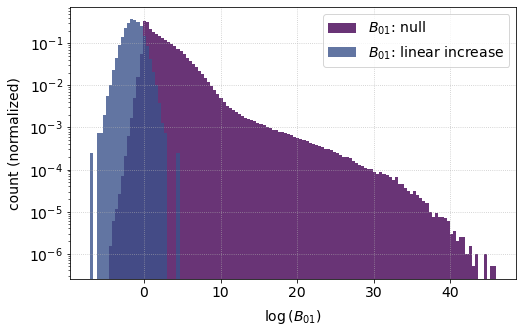

In [166]:
auto_search(1, False, 3)

100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1545.21it/s]


[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  2.  2.  3.  4.  6.  6.  9.
  9.  8.  9. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 324.29it/s]


[ 0.  5.  2. 22. 24. 25. 36. 40. 42. 42. 48. 47.]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.97it/s]


[ 64.  87. 120. 139. 152.]
14


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16391.94it/s]


447.0


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16391.68it/s]


585.0


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16722.42it/s]


[0.5793 0.1013 0.0017]
Amplitude Sensitivity: 1.14


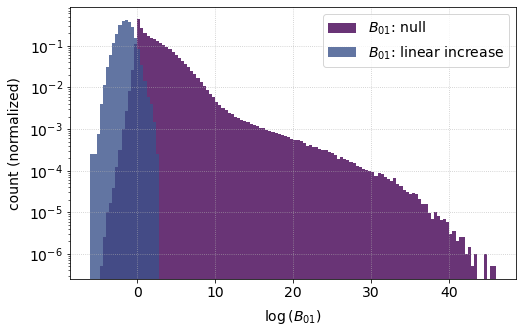

In [167]:
auto_search(1, True, 3)

### Bayes Factor: Linear Model, $5\sigma$ Sensitivity

100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1593.50it/s]


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  2.  2.  2.  5.  3.  3.  4.  6.  6.  9.  7.  7.  8. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 333.40it/s]


[ 4. 11.  8.  9. 17. 24. 28. 23. 34. 38. 44. 49. 46.]


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 84.33it/s]


[ 20.  62.  80.  95. 120. 159. 151.]
25


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16391.62it/s]


430.0


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16391.81it/s]


518.0


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16207.30it/s]


[0.9605 0.8378 0.5327]
Amplitude Sensitivity: 0.75


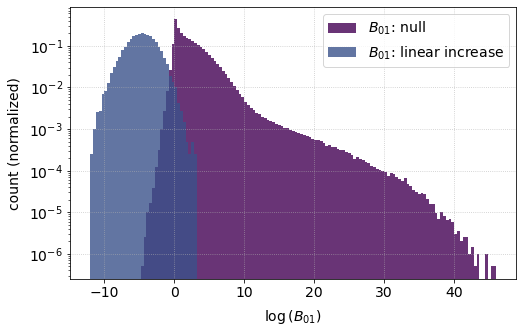

In [168]:
auto_search(1, False, 5)

100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1545.14it/s]


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  2.  5.  4.  7.  4.  9. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 316.00it/s]


[ 9. 14. 22. 30. 38. 37.]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.96it/s]


[ 55.  91. 122. 144. 175.]
20


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16391.75it/s]


272.0


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16391.62it/s]


431.0
21


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16391.81it/s]


451.0


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16393.54it/s]


601.0


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16556.37it/s]


[0.98   0.8927 0.5988]
Amplitude Sensitivity: 1.21


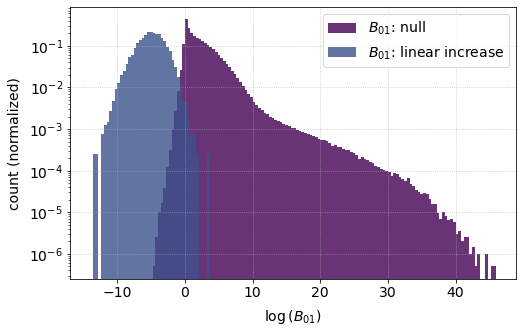

In [169]:
auto_search(1, True, 5)

### Bayes Factor: Step Model, $3\sigma$ Sensitivity

100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1545.19it/s]


[ 0.  0.  0.  0.  0.  2.  3.  8.  3.  6.  9.  9. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 318.09it/s]


[ 5.  7. 17. 26. 28. 41. 47.]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 81.08it/s]


[ 69. 108. 132.]
8


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16127.41it/s]


360.0


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16664.83it/s]


512.0


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16393.43it/s]


[0.5279 0.1167 0.004 ]
Amplitude Sensitivity: 0.92


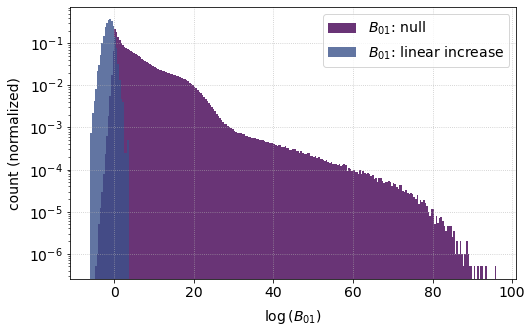

In [170]:
auto_search(2, False, 3)

100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1545.13it/s]


[ 0.  0.  0.  0.  0.  1.  1.  1.  4.  6.  7.  9. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 333.34it/s]


[ 4.  7. 13. 21. 26. 30. 40.]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 83.32it/s]


[ 43.  81. 103. 129. 158.]
9


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16130.39it/s]


376.0


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16391.81it/s]


540.0


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 15999.85it/s]


[0.5363 0.1105 0.0027]
Amplitude Sensitivity: 1.09


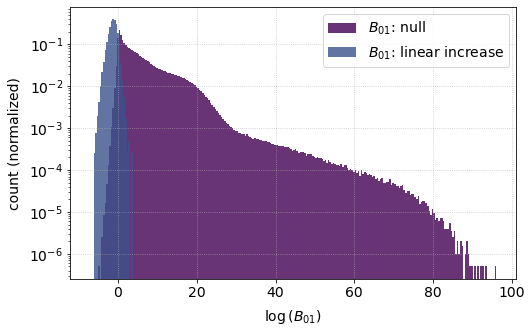

In [171]:
auto_search(2, True, 3)

### Bayes Factor: Step Model, $5\sigma$ Sensitivity

100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1593.40it/s]


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  3.  3. 10.  8.  9. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 312.52it/s]


[11. 13. 26. 42. 47.]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 81.04it/s]


[ 42.  73. 112.]
13


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16393.35it/s]


345.0


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 15625.14it/s]


535.0


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16104.69it/s]


[0.9754 0.8809 0.5468]
Amplitude Sensitivity: 0.87


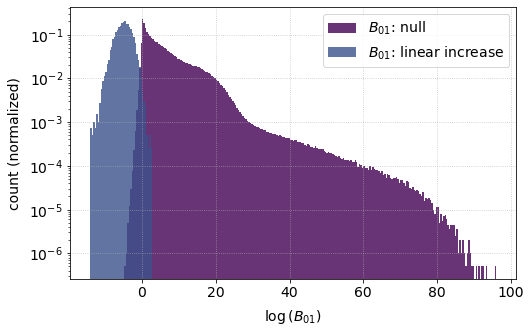

In [172]:
auto_search(2, False, 5)

100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 1593.49it/s]


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  2.  1.  6.  6.  9.
  8.  9. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 321.31it/s]


[ 0.  4.  9. 18. 22. 28. 39. 42. 46.]


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 81.64it/s]


[ 62.  91. 117. 158.]
15


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16392.84it/s]


367.0


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16129.52it/s]


509.0


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16019.46it/s]


[0.9782 0.874  0.4932]
Amplitude Sensitivity: 1.15


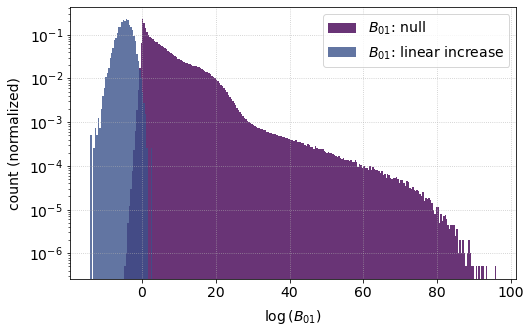

In [173]:
auto_search(2, True, 5)

### Bayes Factor: Burst Model, $3\sigma$ Sensitivity

100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 1636.30it/s]


[ 0.  0.  0.  0.  0.  0.  1.  1.  1.  2.  3.  5.  3.  3.  6.  5.  6.  9.
  6.  8.  9.  9.  8.  9. 10.  9.  9.  8. 10.  9.  9. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 333.34it/s]


[ 2.  7.  7.  6. 10. 15. 17. 19. 27. 30. 25. 27. 30. 39. 41. 40. 40. 43.
 48. 48. 48. 49. 48.]


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 82.76it/s]


[ 43.  55.  68.  83.  85. 102. 116. 122. 144. 139. 158. 178.]
15


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16666.88it/s]


464.0


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16129.21it/s]


533.0


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16207.47it/s]


[0.5358 0.1149 0.0007]
Amplitude Sensitivity: 2.6


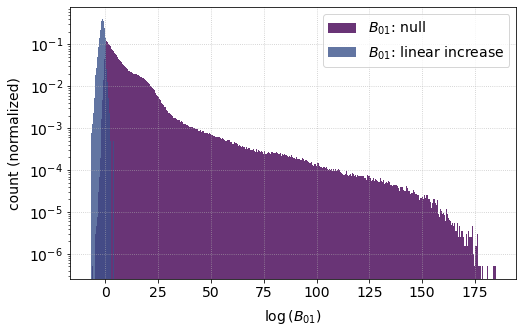

In [174]:
auto_search(3, True, 3)

### Bayes Factor: Burst Model, $5\sigma$ Sensitivity

100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 1636.18it/s]


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  1.  0.  1.  4.  4.  1.  1.  1.  3.  3.  5.  8.  9.
  8.  7.  6.  8.  9.  9. 10.  9. 10.  9.  9. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 343.72it/s]


[ 0.  2.  6.  5. 10.  6. 11. 16. 18. 23. 23. 22. 31. 33. 37. 38. 44. 44.
 47. 48. 49. 47.]


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 83.33it/s]


[ 34.  50.  70.  72.  97. 100. 116. 117. 139. 158. 160.]
32


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16129.46it/s]


385.0


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16129.27it/s]


433.0
33


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 15873.21it/s]


464.0


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16129.15it/s]


531.0


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16286.67it/s]


[0.9881 0.9407 0.5012]
Amplitude Sensitivity: 4.4


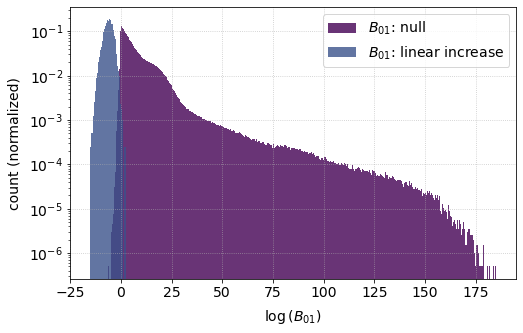

In [175]:
auto_search(3, True, 5)